In [30]:
import geopandas as gpd
import rasterio
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from rasterio.warp import transform_bounds
from tile_mate import get_raster_from_tiles
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
from rasterio.transform import xy
from shapely.geometry import Point
from rasterio.plot import show
from dswx_sar.filter_SAR import lee_enhanced_filter

In [2]:
BURST_ID = 'T018_038457_IW2'.upper().replace('-', '_')

In [3]:
ts_dir = Path('burst_time_series')
burst_dir = ts_dir / BURST_ID
assert burst_dir.exists()

In [4]:
metadata_geojson = burst_dir / f'metadata_{BURST_ID}_rtc_ts.geojson'

In [5]:
df_meta = gpd.read_file(metadata_geojson)
df_meta.head()

,opera_id,start_time,url_vh,url_vv,track_number,local_path_vv,local_path_vh,local_path_vh_tv,local_path_vv_tv,geometry
0,OPERA_L2_RTC-S1_T018-038457-IW2_20231007T23284...,2023-10-07 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56223 -33.27870, -71.50894 -33.2..."
1,OPERA_L2_RTC-S1_T018-038457-IW2_20231019T23284...,2023-10-19 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56304 -33.27879, -71.50975 -33.2..."
2,OPERA_L2_RTC-S1_T018-038457-IW2_20231031T23284...,2023-10-31 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56189 -33.27894, -71.09011 -33.1..."
3,OPERA_L2_RTC-S1_T018-038457-IW2_20231112T23284...,2023-11-12 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56319 -33.27800, -71.09140 -33.1..."
4,OPERA_L2_RTC-S1_T018-038457-IW2_20231124T23284...,2023-11-24 23:28:47+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56064 -33.27817, -71.08885 -33.1..."


Sanity check

In [6]:
def get_trans_and_shape(path: str) -> tuple:
    with rasterio.open(path) as ds:
        t = ds.transform
        s = ds.shape
    return t, s

data = [get_trans_and_shape(path) for path in df_meta.local_path_vh.tolist()]
unique_date = list(set(data))
unique_date

[(Affine(30.0, 0.0, 250470.0,
         0.0, -30.0, 6368190.0),
  (1907, 3440))]

In [7]:
with rasterio.open(df_meta.local_path_vh.tolist()[0]) as ds:
    p_rtc = ds.profile
    bounds = ds.bounds
bounds, p_rtc

(BoundingBox(left=250470.0, bottom=6310980.0, right=353670.0, top=6368190.0),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3440, 'height': 1907, 'count': 1, 'crs': CRS.from_epsg(32719), 'transform': Affine(30.0, 0.0, 250470.0,
        0.0, -30.0, 6368190.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'})

In [8]:
bounds_4326 = transform_bounds(p_rtc['crs'], CRS.from_epsg(4326), *bounds)
bounds_4326

(-71.68024090353879,
 -33.33040515977752,
 -70.56309413811026,
 -32.795944748936236)

# Generate Pekel Water Mask

In [9]:
X_occ, p_occ = get_raster_from_tiles(bounds_4326, tile_shortname='pekel_water_occ_2021')

Reading tile metadata: 100%|█| 1/1 [00:00<00:00, 376
Reading tile imagery: 100%|█| 1/1 [00:04<00:00,  4.9


In [10]:
X_occ = X_occ.astype(np.float32)
p_occ['dtype'] = 'float32'
X_occ_r, _ = reproject_arr_to_match_profile(X_occ, p_occ, p_rtc, resampling='bilinear')

In [11]:
WATER_MASK = (X_occ_r > 95)[0, ...]

In [12]:
p_wtr = p_occ.copy()
p_wtr['dtype'] = np.uint
with rasterio.open(ts_dir / 'water_mask.tif', 'w', **p_wtr) as ds:
    ds.write(WATER_MASK.astype('uint8'), 1)

# Load Time Series

In [13]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X[WATER_MASK] = np.nan
    ## Clip
    if '_VV.tif' == path[-7:]:
        X = np.clip(X, 1e-7, 1)
    else:
        X = np.clip(X, 1e-7, .5)
    return X, p

In [14]:
arrs_vv, profiles = zip(*[open_one(p) for p in tqdm(df_meta.local_path_vv)])
arrs_vh, _ = zip(*[open_one(p) for p in tqdm(df_meta.local_path_vh)])

100%|███████████████| 15/15 [00:01<00:00, 10.44it/s]


In [15]:
acq_dt = df_meta.start_time.tolist()
acq_dt[:2]

[Timestamp('2023-10-07 23:28:48+0000', tz='UTC'),
 Timestamp('2023-10-19 23:28:48+0000', tz='UTC')]

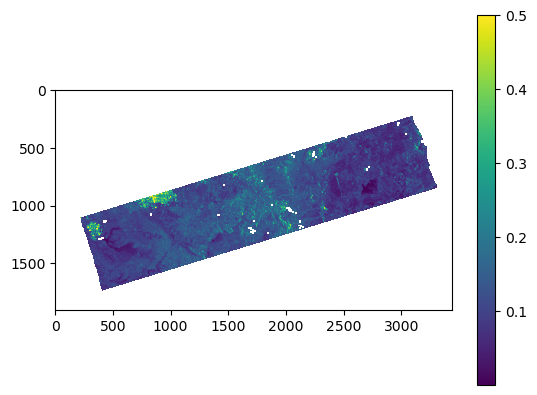

In [16]:
plt.imshow(arrs_vv[0], vmax=.5)
plt.colorbar()

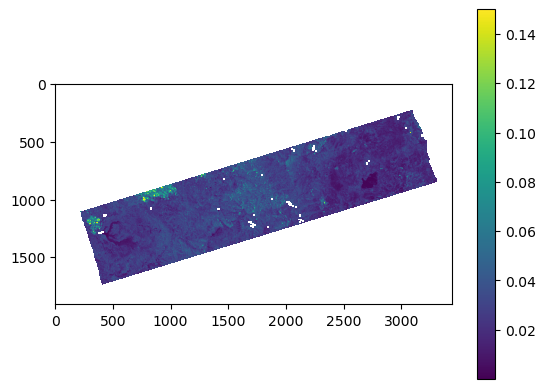

In [17]:
plt.imshow(arrs_vh[0], vmax=.15)
plt.colorbar()

In [106]:
X_vh_samp = arrs_vh[0]
X_vv_samp = arrs_vv[0]

RTC_MASK = np.isnan(X_vh_samp)

# Zoom in

Randomly sampled window

In [109]:
np.random.seed(0)
rows, cols = np.where(~RTC_MASK)
window_size = 200
N = 4  # sample number 143

K = np.random.randint(len(rows), size=len(rows))[N]

sy = np.s_[rows[K] - window_size //2: rows[K] + window_size // 2]
sx = np.s_[cols[K] - window_size //2: cols[K] + window_size // 2]

In [115]:
Z = X_vv_samp[sy, sx]

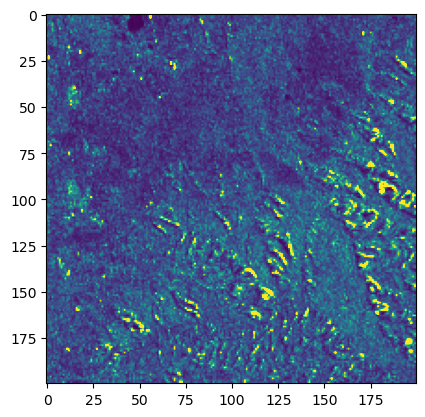

In [118]:
plt.imshow(Z, vmax=.5)

In [119]:
from skimage.restoration import denoise_tv_bregman

In [120]:
def despeckle_one(X: np.ndarray, lamb=8) -> np.ndarray:
    X_db = np.log10(X, out=np.full(X.shape, np.nan), where=(~np.isnan(X)))
    X_db[np.isnan(X)] = 0.
    X_db_dspkl = denoise_tv_bregman(X_db, weight=lamb)
    X_dspkl = np.power(10, X_db_dspkl)
    X_dspkl[np.isnan(X)] = np.nan
    return X_dspkl

In [121]:
ZZ = despeckle_one(Z)
ZZ_lee = lee_enhanced_filter(Z)

>> lee_enhanced_filter


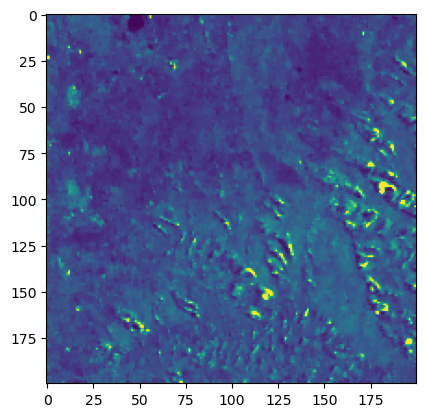

In [124]:
plt.imshow(ZZ, vmax=.5, vmin=0)

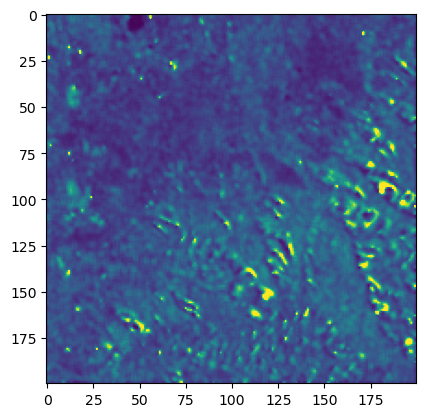

In [125]:
plt.imshow(ZZ_lee, vmax=.5, vmin=0)

In [126]:
X_vh_samp_dspkl = despeckle_one(X_vh_samp)

In [127]:
X_vh_samp_lee = lee_enhanced_filter(X_vh_samp)

>> lee_enhanced_filter


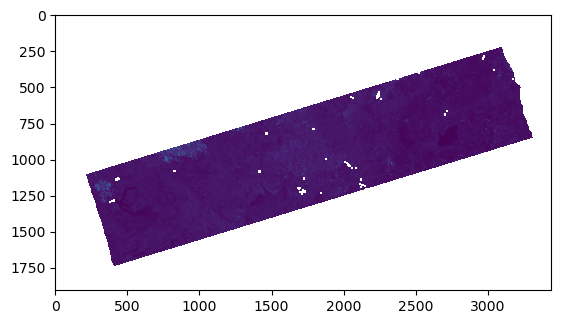

In [128]:
plt.imshow(X_vh_samp)

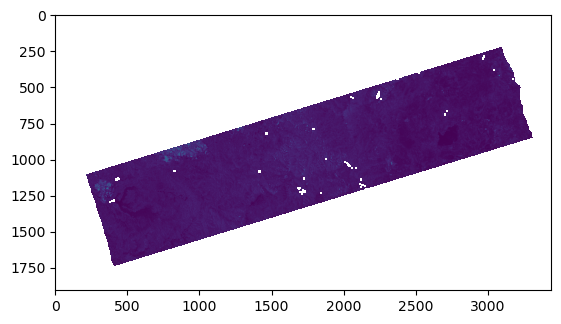

In [129]:
plt.imshow(X_vh_samp_dspkl)

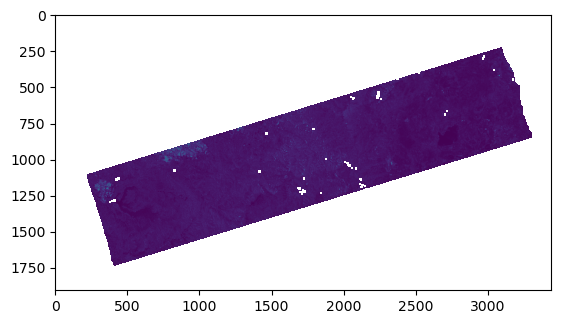

In [130]:
plt.imshow(X_vh_samp_lee)

# Despeckle all

In [83]:
arrs_vv_tv = list(map(despeckle_one, tqdm(arrs_vv)))

100%|███████████████| 15/15 [00:19<00:00,  1.27s/it]


In [131]:
arrs_vh_tv = list(map(despeckle_one, tqdm(arrs_vh)))

100%|███████████████| 15/15 [00:20<00:00,  1.35s/it]


In [132]:
arrs_vv_lee = list(map(lee_enhanced_filter, tqdm(arrs_vv)))

  0%|                        | 0/15 [00:00<?, ?it/s]

>> lee_enhanced_filter


  7%|█               | 1/15 [00:00<00:07,  1.93it/s]

>> lee_enhanced_filter


 13%|██▏             | 2/15 [00:01<00:06,  1.92it/s]

>> lee_enhanced_filter


 20%|███▏            | 3/15 [00:01<00:06,  1.89it/s]

>> lee_enhanced_filter


 27%|████▎           | 4/15 [00:02<00:05,  1.89it/s]

>> lee_enhanced_filter


 33%|█████▎          | 5/15 [00:02<00:05,  1.90it/s]

>> lee_enhanced_filter


 40%|██████▍         | 6/15 [00:03<00:04,  1.87it/s]

>> lee_enhanced_filter


 47%|███████▍        | 7/15 [00:03<00:04,  1.87it/s]

>> lee_enhanced_filter


 53%|████████▌       | 8/15 [00:04<00:03,  1.87it/s]

>> lee_enhanced_filter


 60%|█████████▌      | 9/15 [00:04<00:03,  1.87it/s]

>> lee_enhanced_filter


 67%|██████████     | 10/15 [00:05<00:02,  1.87it/s]

>> lee_enhanced_filter


 73%|███████████    | 11/15 [00:05<00:02,  1.88it/s]

>> lee_enhanced_filter


 80%|████████████   | 12/15 [00:06<00:01,  1.87it/s]

>> lee_enhanced_filter


 87%|█████████████  | 13/15 [00:06<00:01,  1.88it/s]

>> lee_enhanced_filter


 93%|██████████████ | 14/15 [00:07<00:00,  1.87it/s]

>> lee_enhanced_filter


100%|███████████████| 15/15 [00:07<00:00,  1.88it/s]


In [133]:
arrs_vh_lee = list(map(lee_enhanced_filter, tqdm(arrs_vh)))

  0%|                        | 0/15 [00:00<?, ?it/s]

>> lee_enhanced_filter


  7%|█               | 1/15 [00:00<00:07,  1.92it/s]

>> lee_enhanced_filter


 13%|██▏             | 2/15 [00:01<00:06,  1.90it/s]

>> lee_enhanced_filter


 20%|███▏            | 3/15 [00:01<00:06,  1.91it/s]

>> lee_enhanced_filter


 27%|████▎           | 4/15 [00:02<00:05,  1.90it/s]

>> lee_enhanced_filter


 33%|█████▎          | 5/15 [00:02<00:05,  1.91it/s]

>> lee_enhanced_filter


 40%|██████▍         | 6/15 [00:03<00:04,  1.91it/s]

>> lee_enhanced_filter


 47%|███████▍        | 7/15 [00:03<00:04,  1.90it/s]

>> lee_enhanced_filter


 53%|████████▌       | 8/15 [00:04<00:03,  1.89it/s]

>> lee_enhanced_filter


 60%|█████████▌      | 9/15 [00:04<00:03,  1.88it/s]

>> lee_enhanced_filter


 67%|██████████     | 10/15 [00:05<00:02,  1.88it/s]

>> lee_enhanced_filter


 73%|███████████    | 11/15 [00:05<00:02,  1.87it/s]

>> lee_enhanced_filter


 80%|████████████   | 12/15 [00:06<00:01,  1.88it/s]

>> lee_enhanced_filter


 87%|█████████████  | 13/15 [00:06<00:01,  1.89it/s]

>> lee_enhanced_filter


 93%|██████████████ | 14/15 [00:07<00:00,  1.89it/s]

>> lee_enhanced_filter


100%|███████████████| 15/15 [00:07<00:00,  1.89it/s]


# Serialize

In [134]:
paths_vv = list(map(Path, df_meta.local_path_vv))
paths_vh = list(map(Path, df_meta.local_path_vh))
paths_vh[0].name, paths_vh[0].parent.name

('OPERA_L2_RTC-S1_T018-038457-IW2_20231007T232848Z_20231008T182355Z_S1A_30_v1.0_VH.tif',
 'OPERA_L2_RTC-S1_T018-038457-IW2_20231007T232848Z_20231008T182355Z_S1A_30_v1.0')

In [44]:
# #import colormap
# import matplotlib
# from matplotlib import cm

# #normalize item number values to colormap
# norm = matplotlib.colors.Normalize(vmin=0, vmax=.5)

# #colormap possible values = viridis, jet, spectral
# rgba_color = cm.viridis(.15, bytes=True, alpha=1) 
# rgba_color

(69, 52, 127, 255)

In [36]:
# X_int = ((X - .5) / (.5)) * 255
# X_int = rgba.astype(np.uint8)
# X_int[np.isnan(X)] = 255

In [45]:
# plt.imshow(X_int)

In [46]:
# rgba = skimage.color.gray2rgba(X, alpha=1, channel_axis=-1) * 255
# rgba = rgba.astype(np.uint8)


In [47]:
def serialize_one(arr: np.ndarray, src_path: Path) -> str:
    fn = src_path.name
    opera_id = src_path.parent.name

    burst_dir = src_path.parent
    #dst_fn = fn.replace('.tif', '_tv_cmap.tif')
    dst_fn = fn.replace('.tif', '_tv.tif')

    out_path = burst_dir / dst_fn

    # arr_int = ((arr - .5) / (.5)) * 255
    # arr_int = arr_int.astype(np.uint8)
    # arr_int[np.isnan(arr)] = 255
    
    # norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
    # keys = sorted(np.unique(X_int))
    # print(keys)
    # colors = cm.viridis(norm(keys), bytes=True, alpha=1)
    # cmap = {k: tuple(c) for (k, c) in zip(keys, colors)}
    # #cmap[255] = (0, 0, 0, 0)
    # print(cmap)
    p_int = p_rtc.copy()
    # p_int['dtype'] = np.uint8
    # p_int['nodata'] = 255
    with rasterio.open(out_path, 'w', **p_int) as ds:
        ds.write(arr, 1)
        #ds.write_colormap(1, cmap)
    return out_path

In [48]:
vv_tv_paths = [serialize_one(arr, src_path) for (arr, src_path) in zip(tqdm(arrs_vv_tv), paths_vv[:])]

100%|████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.85it/s]


In [49]:
vh_tv_paths = [serialize_one(arr, src_path) for (arr, src_path) in zip(tqdm(arrs_vh_tv), paths_vh)]

100%|████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.78it/s]


In [50]:
df_meta

,opera_id,start_time,url_vh,url_vv,track_number,local_path_vv,local_path_vh,local_path_vh_tv,local_path_vv_tv,geometry
0,OPERA_L2_RTC-S1_T018-038457-IW2_20231007T23284...,2023-10-07 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56223 -33.27870, -71.50894 -33.2..."
1,OPERA_L2_RTC-S1_T018-038457-IW2_20231019T23284...,2023-10-19 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56304 -33.27879, -71.50975 -33.2..."
2,OPERA_L2_RTC-S1_T018-038457-IW2_20231031T23284...,2023-10-31 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56189 -33.27894, -71.09011 -33.1..."
3,OPERA_L2_RTC-S1_T018-038457-IW2_20231112T23284...,2023-11-12 23:28:48+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56319 -33.27800, -71.09140 -33.1..."
4,OPERA_L2_RTC-S1_T018-038457-IW2_20231124T23284...,2023-11-24 23:28:47+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56064 -33.27817, -71.08885 -33.1..."
5,OPERA_L2_RTC-S1_T018-038457-IW2_20231206T23284...,2023-12-06 23:28:47+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56203 -33.27741, -71.09025 -33.1..."
6,OPERA_L2_RTC-S1_T018-038457-IW2_20231218T23284...,2023-12-18 23:28:46+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56162 -33.27754, -71.08988 -33.1..."
7,OPERA_L2_RTC-S1_T018-038457-IW2_20231230T23284...,2023-12-30 23:28:46+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56374 -33.27756, -71.09194 -33.1..."
8,OPERA_L2_RTC-S1_T018-038457-IW2_20240111T23284...,2024-01-11 23:28:45+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,18,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,burst_time_series/T018_038457_IW2/OPERA_L2_RTC...,"POLYGON ((-71.56290 -33.27789, -71.

In [51]:
df_meta['local_path_vh_tv'] = list(map(str, vh_tv_paths))
df_meta['local_path_vv_tv'] = list(map(str, vv_tv_paths))
df_meta.to_file(metadata_geojson)